In [1]:
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
from types import SimpleNamespace
%matplotlib inline

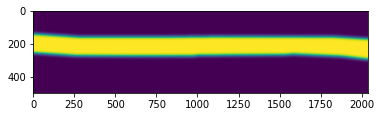

In [2]:
#designfile = '/users/tkm/kanilmaz/thesis/designfiles/hb_lower_part.png'
#designfile = '/home/nefta/thesis/designfiles/qpc.png'
designfile = '/home/nefta/thesis/designfiles/full_gate.png'
topgate = 1 - scipy.ndimage.imread(designfile, mode='L').T / 255
topgate[0] = np.zeros(len(topgate[0]))
topgate[1] = np.zeros(len(topgate[0]))
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, 10)
plt.imshow(topgate_gauss)

In [3]:
#scipy.ndimage.imread(
#    '/users/tkm/kanilmaz/thesis/designfiles/scatteringRegion_sleeves.png')

In [4]:
#scattering_region = np.ones(topgate_gauss.shape)
#scattering_region = 1 - scipy.ndimage.imread(
#    '/users/tkm/kanilmaz/thesis/designfiles/scatteringRegion_sleeves.png').T / 255)
#scattering_region = 1 - scipy.ndimage.imread(
#    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255
scattering_region = np.fliplr(1 - scipy.ndimage.imread(
    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255)

In [8]:
delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5
a = 0.15
#a = 0.4
a_s = 0.0000001 * at # shift in one lattice for calculating and plotting current density

bilayer =  kwant.lattice.general([(at*np.sqrt(3)/2, at*1/2), (0, at*1)],
                                 [(0+a_s, 0.0+a_s), (at*1 / (2*np.sqrt(3))+a_s, at*1/2+a_s), 
                                  (-at*1/(2*np.sqrt(3)), at*1/2), (0, 0)], norbs=1)

a1, b1, a2, b2 = bilayer.sublattices
hoppings1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((1, 0), a1, b1)) 
hoppings2 = (((0, 0), a2, b2), ((0, -1), a2, b2), ((1, -1), a2, b2))

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss,
    kx=1,
    ky=1,
)

In [9]:
def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    # site.family in (a1, b1)
    if (site.family == a1 or site.family == b1):
        return - mu - delta 
    return -mu + delta

def onsite_lead(site, par):     
    topgate_potential = 0
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta

def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False
    
def trs(m):
    return m.conj()

class TRIInfiniteSystem(kwant.builder.InfiniteSystem):
    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes =             super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2*n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2*n)] =             self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] =             self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes

def make_system():
    #system = kwant.Builder(time_reversal=1)
    system = kwant.Builder()
    scat_width = scattering_region.shape[0]
    scat_length = scattering_region.shape[1]

    system[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite 
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    system[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer    

    trans_sym_1 = kwant.TranslationalSymmetry(bilayer.vec((-2, 1)))
    lead_1 = kwant.Builder(trans_sym_1, time_reversal=1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    system.attach_lead(lead_1)

    trans_sym_2 = kwant.TranslationalSymmetry(bilayer.vec((2, -1))) #?
    lead_2 = kwant.Builder(trans_sym_2, time_reversal=1)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    system.attach_lead(lead_2)
    system = system.finalized()
    #system.leads = [TRIInfiniteSystem(lead, trs) for lead in system.leads]#
    return(system)

In [10]:
def family_colors(site):
    delta = 1.0 - potential(site.pos[0], site.pos[1])[0][0]
    if delta < 0.9:    
        return('black')
    else:
        return('grey')

In [11]:
system = make_system()


In [78]:
#fig = kwant.plotter.plot(system, fig_size=(16, 9))#, site_color=family_colors, unit=3)

In [12]:
def andreev_states(sys, par, phi, Delta):
    s = kwant.smatrix(sys, energy = 0, args=[par])
    n_modes = [len(li.momenta) for li in s.lead_info]
    s = s.data
    dim1 = int(n_modes[0] / 2)
    dim2 = int(n_modes[1] / 2)
    r_a11 = 1j*np.eye(dim1)
    r_a12 = np.zeros((dim1, dim2))
    r_a21 = r_a12.T
    r_a22 = 1j*np.exp(- 1j * phi) * np.eye(dim2)
    r_a = np.bmat([[r_a11, r_a12], [r_a21, r_a22]])
    A = (r_a.dot(s) + (s.T).dot(r_a)) / 2
    eigVl, eigVc = la.eigh(A.T.conj().dot(A))
    eigVl **= 0.5
    eigVl = eigVl * Delta
    eigVc = eigVc.T
    return eigVl, eigVc

In [13]:
def andreev_wf(eigVal, eigVec, kwant_wf, T):
    #T = kb * Temp
    l = len(eigVc)
    andreev = []
    w = np.vstack((kwant_wf(0), kwant_wf(1)))
    and_wf = [np.dot(Vec, w)* np.tanh(eigVal/(2*T)) for (Vec, eigVal) in zip(eigVec, eigVal)]
    return and_wf

In [19]:
par = SimpleNamespace(t=1, eta=2.5, gamma1=0.4, B=0.000, v_sg=-0.0, v_bg=0.5, v_dis=0.0)
#par = {'t': 1, 'eta': 3.5, 'gamma1': 0.4, 'B': 0.0,' v_sg': -0.6, 'v_bg': 0.2, 'v_dis': 0.0}

In [20]:
wf = kwant.wave_function(system, energy=0.0, args=(par,))
#wf = kwant.wave_function(system, energy=0.0, params=vars(par),)
eigVl, eigVc = andreev_states(system, par, np.pi/2, delta)
ABS = andreev_wf(eigVl, eigVc, wf, T)

In [21]:
def intensity(syst, psi, args):
    I_operator = kwant.operator.Current(syst, onsite=1)
    current = []
    for i in range(len(psi)):
        I = I_operator(psi[i], args=args)
        current.append(I)
    I = sum(current)
    return I

In [22]:
I = intensity(system, ABS, args=[par])

In [23]:
I

array([  1.67255261e-14,  -4.64217423e-15,   5.39514417e-15, ...,
        -7.21909240e-14,  -1.68152384e-13,  -1.08377866e-15])

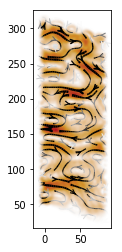

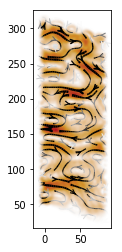

In [24]:
kwant.plotter.current(system, I)